In [1]:
import numpy as np
from sklearn import datasets

# Run the following before any XLA modules such as JAX:
import chex

# chex.set_n_cpu_devices(2)

# Add end-to-end package to path.
import sys
from pathlib import Path

sys.path.append(str(Path('../src').absolute()))

# Import the remaining JAX related 
from gabenet.mcmc import sample_markov_chain
from gabenet.nets import MultinomialDirichletBelieve

import haiku as hk

2023-07-11 12:44:43.342618: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


To illustrate how to use the multinomial-Dirichlet believe network, we will train the
model on the MNIST dataset, containing handwritten digits.

The dataset can directly be loaded from scikit-learn. As preprocessing step, we reshape the
digits from a 8x8 square matrix to a flat array of size 64.

In [2]:
digits = datasets.load_digits()
n_samples = len(digits.images)
X_train = digits.images.reshape((n_samples, -1))

Next, we define the model. We use a simple decoder network with two hidden layers. In
total, the size of the network: 2 x 10 x 64.

```
n_hidden_units = (2, 10)
model = MultinomialDirichletBelieve(n_hidden_units, n_features)
```

This function has to be defined in a [haiku](https://github.com/deepmind/dm-haiku) context to transform the network in a pure state for JAX.

Since the network is a Bayesian model, we don't train the model by
minimising a loss. Rather, we infer the distribution $p(\boldsymbol{\theta}|\boldsymbol{X}_{\mathrm{train}})$ of the model's parameters $\boldsymbol{\theta}$ given the training data $\boldsymbol{X}_{\mathrm{train}}$ that we observe. This probability distribution is called the [posterior](https://en.wikipedia.org/wiki/Posterior_probability).

Unfortunately, we don't know what this distribution is. However, we do know a way how to sample it: using Markov chain Monte Carlo (MCMC). This simulation method samples the distributions by taking small steps that depend on its previous state. In theory, when we have take enough steps, the state converges to the true (posterior) distribution.

First, initialise the chain using training data:

```python
model.init(X_train)
```

This method takes samples from the prior as a starting point. After that, keep taking steps from your current to your next state. To take one step, you simply call your model using
the training data:

```python
model(X_train)
```

This function call does one Gibbs sampling step, which updates all the parameters one-by-one.

Now, lets put all elements together.

In [3]:
# Pseudo-random number generator sequence.
key_seq = hk.PRNGSequence(42)

m_samples, n_features = X_train.shape

@hk.transform_with_state
def kernel():
    """Advance the Markov chain by one step."""
    n_hidden_units = (10, )
    model = MultinomialDirichletBelieve(n_hidden_units, n_features)
    if hk.running_init():
        # Initialise Markov chain.
        model.init(X_train)

    # Do one Gibbs sampling step.
    model(X_train)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
params, state = kernel.init(next(key_seq))
state['multinomial_dirichlet_believe/~/cap_layer']['r'].block_until_ready()

Array([5.1007801e-01, 3.7258615e-25, 6.6692219e-03, 5.5523387e-08,
       5.0742415e-08, 1.1700398e-01, 2.1399991e-17, 3.6347800e-01,
       1.1877611e-09, 2.7706921e-03], dtype=float32)

In [5]:
params, state = kernel.apply(params, state, next(key_seq))
state['multinomial_dirichlet_believe/~/cap_layer']['r'].block_until_ready()

Array([5.0151855e-01, 3.2134609e-05, 7.0774397e-03, 3.1438991e-16,
       6.3737040e-15, 1.2054221e-01, 1.8244776e-06, 3.6653900e-01,
       9.0008516e-06, 4.2798021e-03], dtype=float32)

Here, we defined a function that proposes a new state based on its current configuration. This is called a _kernel_. The `hk.transform_with_state` decorator uses haiku to purify the function into something that is stateless.

Finally, we draw samples from the Markov chain. We first take 100 burn-in steps, in the
hope that the chain converges to the true distribution. After throwing away these first 100 samples, we collect a new set
of 100 samples (50 in each chain) to estimate the posterior distribution.

Note that `sample_markov_chain` (below) automatically takes care of distributing your
computation across multiple devices. For simplicity, we assume you are running on a CPU and split the CPU up in two virtual devices. (See above, at the import section, where we've used
`chex` set the number of devices to 2.)

The following cell, that collects statistics from the Markov chain takes, about `10 minutes` to run on a CPU.

In [6]:
params, states = sample_markov_chain(
    next(key_seq),
    kernel=kernel,
    n_samples=50, 
    n_burnin_steps=50, 
    n_chains=1,
)

_ = states['multinomial_dirichlet_believe/~/multinomial_layer']['phi'].block_until_ready()
# jax.profiler.save_device_memory_profile('/tmp/mcmc/sample.prof')

/home/hylke/workspace/gabenet/examples/../src/gabenet/mcmc.py:95: UserWarning: Only one visible device in JAX. Reconfigure XLA_FLAGS.
  warnings.warn("Only one visible device in JAX. Reconfigure XLA_FLAGS.")


After training the model, we can inspect what the model has learned. Note that, instead of a single point estimate of the parameters, we've obtained a distribution. To visualise the parameters, we take for simplicity the median. Let's take a look at $\bm{\Phi}^{(1)}$, the weights of the first layer.

In [6]:
from functools import partial
from typing import Any, Callable, Optional
import warnings

import haiku as hk
import jax
from jax import random
import jax.numpy as jnp

from gabenet.sugar import scannable

def sample_markov_chain3(    key,
    kernel: Callable[[tuple], tuple[Any, dict]] | hk.TransformedWithState,
    n_samples: int,
    n_burnin_steps: int,
    n_chains: Optional[int] = None,
    params: Optional[hk.Params] = None,
    initial_state: Optional[hk.State] = None,
    n_leap_size: int = 1,
):
    key_seq = hk.PRNGSequence(key)
    n_samples_per_chain = n_samples // n_chains

    states = []
    params = []
    for i in range(n_chains):
        param, state = kernel.init(next(key_seq))
        print('----------------------')
        for _ in range(n_burnin_steps):
            _, state = kernel.apply(param, state, next(key_seq))
        for _ in range(n_samples_per_chain):
            _, state = kernel.apply(param, state, next(key_seq))
            states.append(state)
        print('---------------------')
        params.append(param)

    params_tree = jax.tree_util.tree_map(lambda *x: jnp.stack(x), *params)
    states_tree = jax.tree_util.tree_map(lambda *x: jnp.stack(x), *states)
    return params_tree, states_tree

with jax.log_compiles(True):
    params, states = sample_markov_chain3(
        next(key_seq),
        kernel=kernel,
        n_samples=50, 
        n_burnin_steps=50, 
        n_chains=1,
    )

    _ = states['multinomial_dirichlet_believe/~/multinomial_layer']['phi'].block_until_ready()
# jax.profiler.save_device_memory_profile('/tmp/gabenet/sample2.prof')

----------------------


---------------------


In [10]:

def sample_markov_chain2(
    key,
    kernel: Callable[[tuple], tuple[Any, dict]] | hk.TransformedWithState,
    n_samples: int,
    n_burnin_steps: int,
    n_chains: Optional[int] = None,
    params: Optional[hk.Params] = None,
    initial_state: Optional[hk.State] = None,
    n_leap_size: int = 1,
):

    key_seq = hk.PRNGSequence(key)

    _scannable_kernel_fn = scannable(kernel)

    if initial_state is None or params is None:
        if not isinstance(kernel, hk.TransformedWithState):
            raise ValueError(
                "Kernel must be `TransformedWithState` to be able to initialise"
                "`params` and `state` when either is None."
            )
        if n_chains is None:
            raise ValueError("Number of chains not specified!")

        init_key_per_chain = random.split(next(key_seq), num=n_chains)
        params, initial_state = jax.vmap(kernel.init)(init_key_per_chain)


    def _leapfrog(carry, _):
        """A for-loop (from 0,..,`n_steps-1`) that runs `step`."""
        carry_out, _ = jax.lax.scan(
            _scannable_kernel_fn, carry, xs=None, length=n_leap_size
        )
        state = carry_out[1]
        return carry_out, state

    def _sampler(params_init, state_init, key, n_sample_size: int):
        """Samper for a single Markov chain."""
        carry = (params_init, state_init, key)
        # 1) Take first sample after `(n_burnin - n_leap_size) + n_leap_size` steps.
        n_steps = n_burnin_steps - n_leap_size
        carry, _ = jax.lax.scan(_scannable_kernel_fn, carry, xs=None, length=n_steps)
        # 2) Take subsequent samples after `n_leap_size` steps.
        _, stacked_states = jax.lax.scan(
            _leapfrog, carry, xs=None, length=n_sample_size
        )

        return stacked_states

    n_devices = jax.local_device_count()


    # Generate an initial state for each chain.
    keys = random.split(next(key_seq), num=n_chains)

    n_samples_per_chain = n_samples // n_chains
    _vectorised_kernel_fn = jax.vmap(
        partial(_sampler, n_sample_size=n_samples_per_chain), in_axes=(0, 0, 0)
    )
    state = _vectorised_kernel_fn(params, initial_state, keys)
    return params, state

with jax.log_compiles(True):
    params, states = sample_markov_chain2(
        next(key_seq),
        kernel=kernel,
        n_samples=50, 
        n_burnin_steps=50, 
        n_chains=1,
    )

    _ = states['multinomial_dirichlet_believe/~/multinomial_layer']['phi'].block_until_ready()
# jax.profiler.save_device_memory_profile('/tmp/gabenet/sample2.prof')

<Figure size 640x480 with 0 Axes>

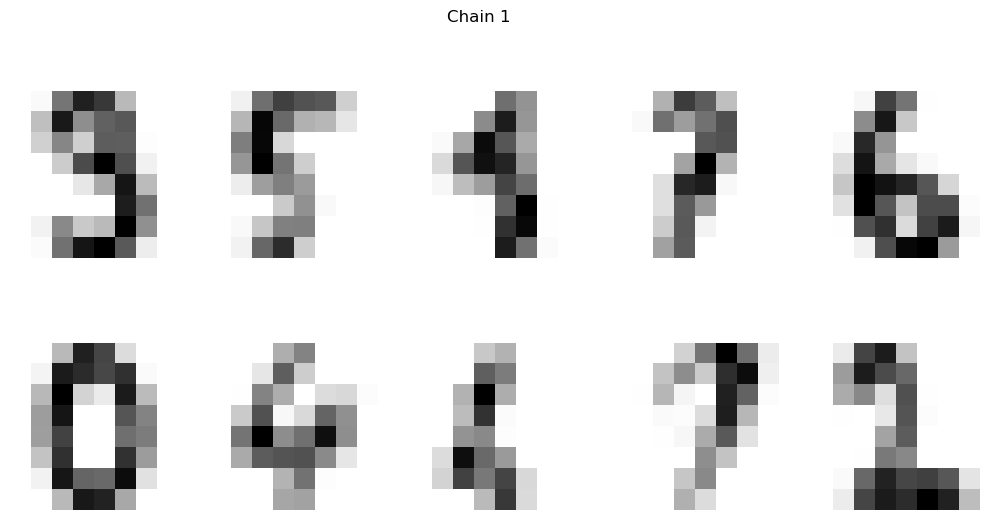

<Figure size 640x480 with 0 Axes>

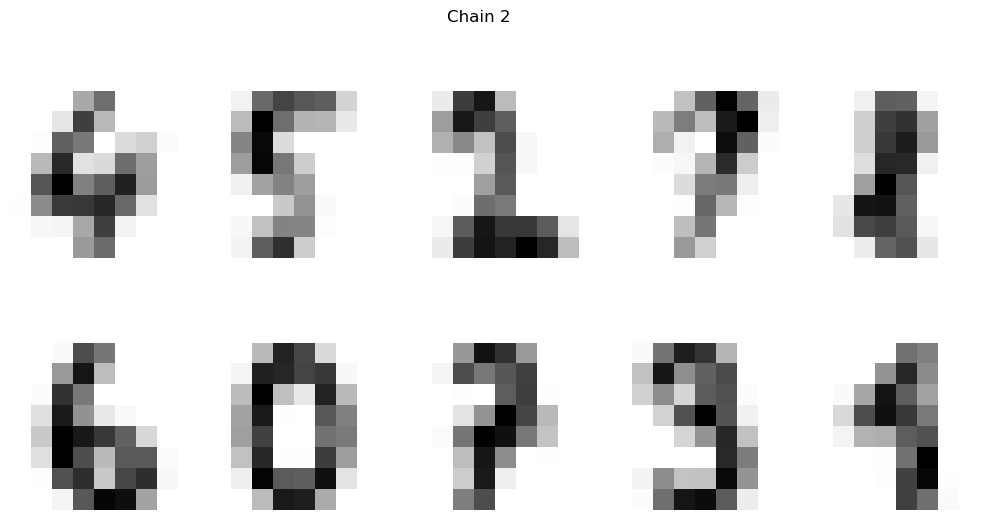

In [9]:
from matplotlib import pyplot as plt

# Aggregate posterior samples to visualise.
phi_1st_layer = np.median(states['multinomial_dirichlet_believe/~/multinomial_layer']['phi'], axis=[1])

for i in range(2):  # For each Markov chain.
    plt.figure()
    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(12.5, 6))
    plt.suptitle(f'Chain {i+1}')
    # Plot the weights of all 10 hidden states.
    for ax, phi in zip(axes.flatten(), phi_1st_layer[i]):
        ax.set_axis_off()
        image = phi.reshape(8, 8)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")